In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, log2

import category_encoders as ce

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

CV_verbose_param = 1

In [2]:
# load dataset
dataset = pd.read_csv('dataset/spotify_tracks_cleaned.csv')
dataset.head()

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,...,GENRE_spanish,GENRE_study,GENRE_swedish,GENRE_synth-pop,GENRE_tango,GENRE_techno,GENRE_trance,GENRE_trip-hop,GENRE_turkish,GENRE_world-music
0,Rill,Lolly,Lolly,160725,True,0.910,0.374,8,-9.844,0,...,0,0,0,0,0,0,0,0,0,0
1,Glee Cast,Glee Love Songs,It's All Coming Back To Me Now (Glee Cast Vers...,322933,False,0.269,0.516,0,-7.361,1,...,0,0,0,0,0,0,0,0,0,0
2,Paul Kalkbrenner;Pig&Dan,X,Böxig Leise - Pig & Dan Remix,515360,False,0.686,0.560,5,-13.264,0,...,0,0,0,0,0,0,0,0,0,0
3,Jordan Sandhu,Teeje Week,Teeje Week,190203,False,0.679,0.770,0,-3.537,1,...,0,0,0,0,0,0,0,0,0,0
4,Paul Kalkbrenner,Zeit,Tief,331240,False,0.519,0.431,6,-13.606,0,...,0,0,0,0,0,0,0,0,0,0


<span style="color:blue">**NUMERICAL**</span> and <span style="color:red">**CATEGORICAL**</span> features of the dataset :

- <span style="color:red">***artists***</span>: The artists' names who performed the track. If there is more than one artist, they are separated by a ;

- <span style="color:red">***album_name***</span>: The album name in which the track appears

- <span style="color:red">***track_name***</span>: Name of the track

- <span style="color:orange">***popularity***</span>: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

- <span style="color:blue">***duration_ms***</span>: The track length in milliseconds

- <span style="color:red">***explicit***</span>: Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)

- <span style="color:blue">***danceability***</span>: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

- <span style="color:blue">***energy***</span>: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
 
- <span style="color:red">***key***</span>: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
    
- <span style="color:blue">***loudness***</span>: The overall loudness of a track in decibels (dB)

- <span style="color:red">***mode***</span>: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
    
- <span style="color:blue">***speechiness***</span>: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
    
- <span style="color:blue">***acousticness***</span>: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
    
- <span style="color:blue">***instrumentalness***</span>: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
    
- <span style="color:blue">***liveness***</span>: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
    
- <span style="color:blue">***valence***</span>: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
    
- <span style="color:blue">***tempo***</span>: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
    
- <span style="color:red">***time_signature***</span>: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
    
- <span style="color:red">***GENRE_{genre_name}***</span>: Whether or not the track belongs to the genre genre_name

In [7]:
# taking the number of artists as a column does not improve the results

#dataset['#artists'] = dataset['artists'].map(lambda x: len(x.split(';')))
#dataset['#artists'].corr(dataset['popularity'])

In [6]:
X = dataset.drop(columns=['popularity'])    # features
y = dataset['popularity']                   # target variable

#### Categorical features encoding

***mode*** and ***GENRE_{genre_name}*** are binary categorical feature already mapped in {0,1}

***explicit*** is a binary categorical feature that we map in {0,1}

In [7]:
X['explicit'] = X['explicit'].map({False : 0, True : 1})

***key*** and ***time_signature*** are categorical features on which we apply one-hot encoding

In [8]:
features = ['key', 'time_signature']

ohe = ce.OneHotEncoder(cols=features) 
X = ohe.fit_transform(X)

for f in features:
    print(f'{dataset[f].nunique():>4} columns used to one-hot encode {f}')

  12 columns used to one-hot encode key
   5 columns used to one-hot encode time_signature


***artists***, ***album_name*** and ***track_name*** are categorical features with a large number of distinct values on which we apply binary encoding

In [9]:
features = ['artists', 'album_name', 'track_name']

be = ce.BinaryEncoder(cols=features)
X = be.fit_transform(X)

for f in features:
    print(f'{ceil(log2(dataset[f].nunique())):>4} columns used to binary encode {f}')

  15 columns used to binary encode artists
  16 columns used to binary encode album_name
  17 columns used to binary encode track_name


In [10]:
X['popularity_subsamples'] = y.map(lambda x: x if x % 2 == 0 else x+1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['popularity_subsamples'])

X_train.drop(columns='popularity_subsamples', inplace=True)
X_test.drop(columns='popularity_subsamples', inplace=True)

In [11]:
X_train['mode'].corr(y_train)

-0.014134122062802425

In [12]:
X_train['explicit'].corr(y_train)

0.05345766099560088

In [13]:
worst_features = ['energy', 'liveness', 'valence', 'tempo']
X_train.drop(columns=worst_features, inplace=True)
X_test.drop(columns=worst_features, inplace=True)

### Features normalization

In [14]:
standard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

## *Ridge Regression* on *Spotify Tracks Dataset*

In [15]:
from ridge_regression import RR

### Hyperparameters tuning

In [19]:
λ_grid = np.linspace(0, 500, num=20)

learner = GridSearchCV(estimator=RR(), n_jobs=-1, param_grid={'λ': λ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=RR(), n_jobs=-1,
             param_grid={'λ': array([  0.        ,  26.31578947,  52.63157895,  78.94736842,
       105.26315789, 131.57894737, 157.89473684, 184.21052632,
       210.52631579, 236.84210526, 263.15789474, 289.47368421,
       315.78947368, 342.10526316, 368.42105263, 394.73684211,
       421.05263158, 447.36842105, 473.68421053, 500.        ])},
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
print(f'Best hyperparams : λ = {learner.best_params_["λ"]}')

Best hyperparams : λ = 131.57894736842104


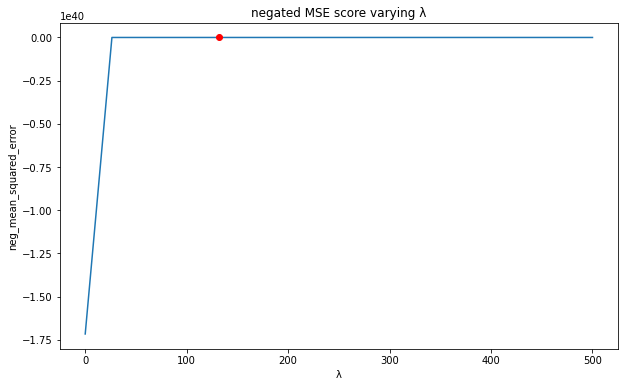

In [21]:
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)
ax.plot(learner.cv_results_['param_λ'].data, learner.cv_results_['mean_test_score'])
ax.plot(learner.best_params_['λ'], learner.best_score_, 'ro') 
ax.set(xlabel='λ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ')
plt.show()

In [23]:
rr = learner.best_estimator_
rr.fit(X_train, y_train)
y_prediction = rr.predict(X_test)

print('   MSE :', mean_squared_error(y_test, y_prediction))
print('   MAE :', mean_absolute_error(y_test, y_prediction))
print('    R2 :', r2_score(y_test, y_prediction))

   MSE : 259.4665233971886
   MAE : 11.926071759531634
    R2 : 0.3860327640836603


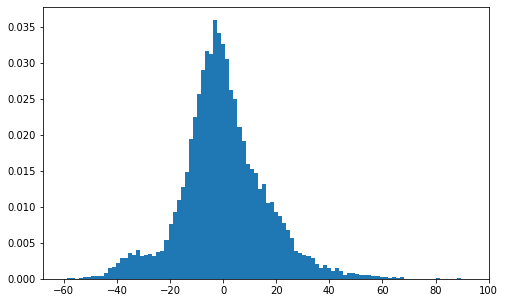

In [24]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(5)
ax.hist(y_test - y_prediction, density=True, bins=100)
plt.show()

## *Kernel Ridge Regression* on *Spotify Tracks Dataset*

In [25]:
from kernel_ridge_regression import KRR

We run KRR just on samples of the dataset because, otherwise, it would get too computationally expensive 

In [26]:
train_sample_size = 5000
test_sample_size = 1000

X_train_sample = X_train.sample(n=train_sample_size, random_state=1)
y_train_sample = pd.Series(data = [y_train[i] for i in X_train_sample.index], index = X_train_sample.index)

X_test_sample = X_test.sample(n=test_sample_size, random_state=1)
y_test_sample = pd.Series(data = [y_test[i] for i in X_test_sample.index], index = X_test_sample.index)

### Hyperparameters tuning

In [27]:
λ_grid = 10. ** np.arange(-2, 3) 
γ_grid = 10. ** np.arange(0, 5) 

learner = GridSearchCV(estimator=KRR(), n_jobs=-1, param_grid={'λ': λ_grid, 'γ': γ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train_sample, y_train_sample)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=KRR(), n_jobs=-1,
             param_grid={'γ': array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'λ': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
print(f'Best hyperparams : λ = {learner.best_params_["λ"]} , γ = {learner.best_params_["γ"]}')

Best hyperparams : λ = 0.01 , γ = 1000.0


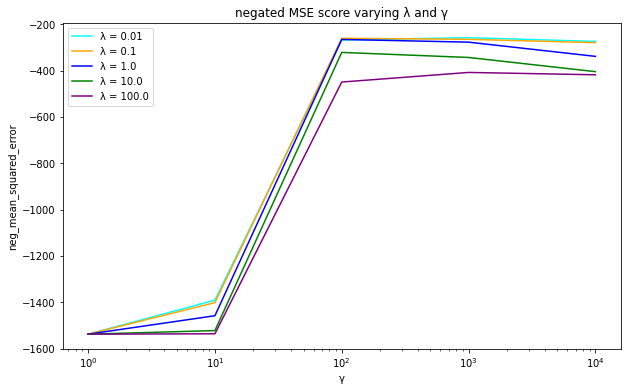

In [29]:
# preparing the data to plot

score = learner.cv_results_['mean_test_score']

dict_λ = {}
for v in set(learner.cv_results_['param_λ'].data):
    dict_λ[v] = (sorted(set(learner.cv_results_['param_γ'].data)), [])
for i, p in enumerate(learner.cv_results_['params']):
    dict_λ[p['λ']][1].append(score[i])
#del(dict_λ[0.0])

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

colors = ['purple', 'green', 'blue', 'orange', 'cyan']
for k in sorted(dict_λ.keys()):
    ax.plot(dict_λ[k][0], dict_λ[k][1], label = f"λ = {k}", linestyle="-", color = colors.pop())

ax.set(xscale='log', xlabel='γ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ and γ')
plt.legend()
plt.show()

In [30]:
train_sample_size_BIG = 20000
test_sample_size_BIG = 4000

X_train_sample_BIG = X_train.sample(n=train_sample_size_BIG, random_state=1)
y_train_sample_BIG = pd.Series(data = [y_train[i] for i in X_train_sample_BIG.index], index = X_train_sample_BIG.index)

X_test_sample_BIG = X_test.sample(n=test_sample_size_BIG, random_state=1)
y_test_sample_BIG = pd.Series(data = [y_test[i] for i in X_test_sample_BIG.index], index = X_test_sample_BIG.index)

In [31]:
krr = learner.best_estimator_
krr.fit(X_train_sample_BIG, y_train_sample_BIG)
y_prediction = krr.predict(X_test_sample_BIG)

print('   MSE :', mean_squared_error(y_test_sample_BIG, y_prediction))
print('   MAE :', mean_absolute_error(y_test_sample_BIG, y_prediction))
print('    R2 :', r2_score(y_test_sample_BIG, y_prediction))

   MSE : 212.43260724231072
   MAE : 10.500670877243746
    R2 : 0.4735310184590851


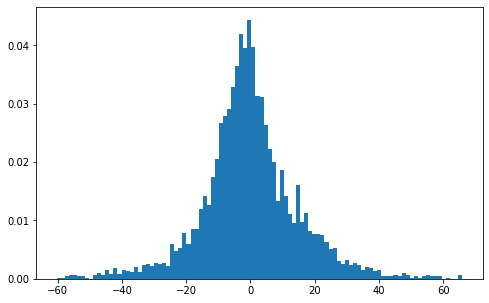

In [38]:
fig, ax = plt.subplots()
fig.set_figwidth(8)
fig.set_figheight(5)
ax.hist(y_test_sample_BIG - y_prediction, density=True, bins=100)
plt.show()